In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
datasets = ["DTD","EuroSAT","GTSRB"]

In [16]:
def calc_tpr(targ, pred):
    tp = np.sum((targ == 1) & (pred == 1))
    fn = np.sum((targ == 1) & (pred == 0))
    return tp / (tp + fn)
def calc_fpr(targ, pred):
    fp = np.sum((targ == 0) & (pred == 1))
    tn = np.sum((targ == 0) & (pred == 0))
    return fp / (fp + tn)
def predict_correctness(ent_ls,threshold):
    return np.where(ent_ls>threshold,0,1)
def auroc(pred_vec, target_vec, unc_vec, label):
    cor_pred = np.where(pred_vec == target_vec, 1, 0)
    max_unc = unc_vec.max()
    min_unc = unc_vec.min()
    tpr = np.array([]) 
    fpr = np.array([])
    step = (max_unc - min_unc)/100
    for ent_step in np.arange(min_unc, max_unc, step):
        temp = predict_correctness(unc_vec, ent_step)
        tpr = np.append(tpr, calc_tpr(cor_pred, temp))
        fpr = np.append(fpr, calc_fpr(cor_pred, temp))
    
    area = np.trapz(tpr, fpr)
    sns.lineplot(x=fpr, y=tpr, label=f"{label} (AUC: {area:.2f})")
    return area

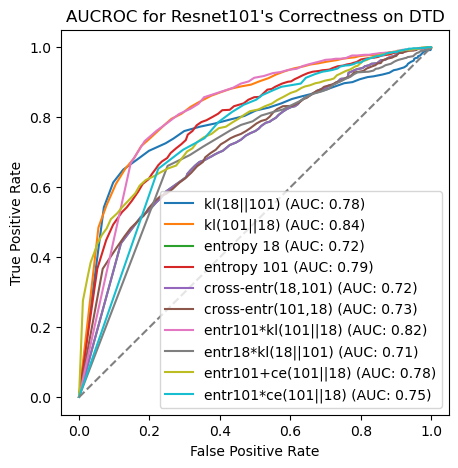

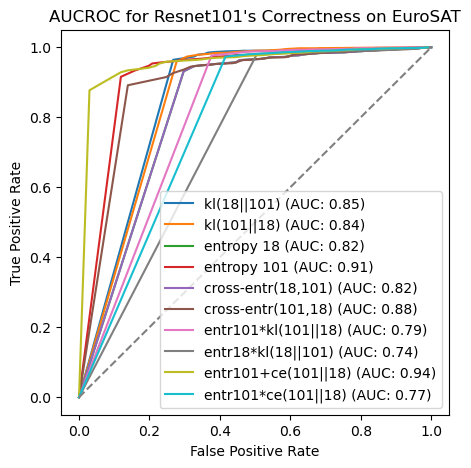

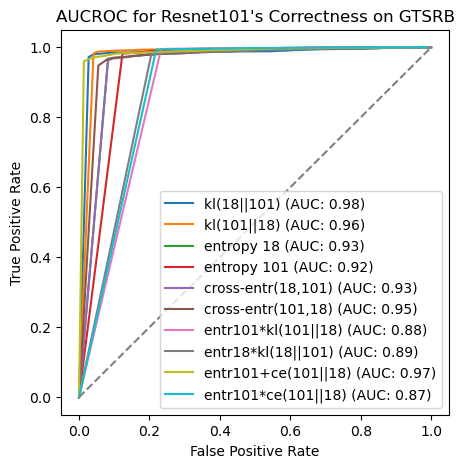

In [17]:
for ds in datasets:
    pred = pd.read_csv(f"prediction_{ds}.csv",index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv",index_col="Unnamed: 0")
    plt.figure(figsize=[5,5])
    auroc(pred["pred101"], pred["target"], unc_pred["kl_18_101"], "kl(18||101)")
    auroc(pred["pred101"], pred["target"], unc_pred["kl_101_18"], "kl(101||18)")
    auroc(pred["pred101"], pred["target"], unc_pred["ent_18"], "entropy 18")
    auroc(pred["pred101"], pred["target"], unc_pred["ent_101"], "entropy 101")
    auroc(pred["pred101"], pred["target"], unc_pred["ce_18_101"], "cross-entr(18,101)")
    auroc(pred["pred101"], pred["target"], unc_pred["ce_101_18"], "cross-entr(101,18)")
    auroc(pred["pred101"], pred["target"], unc_pred["ent_101"] * unc_pred["kl_101_18"], "entr101*kl(101||18)")
    auroc(pred["pred101"], pred["target"], unc_pred["ent_18"] * unc_pred["kl_18_101"], "entr18*kl(18||101)")
    auroc(pred["pred101"], pred["target"], unc_pred["ent_101"] + unc_pred["ce_101_18"], "entr101+ce(101||18)")
    auroc(pred["pred101"], pred["target"], unc_pred["ent_101"] * unc_pred["ce_101_18"], "entr101*ce(101||18)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"AUCROC for Resnet101's Correctness on {ds}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.show()